# TP d'OCVX : démélange spectral par moindres carrés et régularisation 

**/!\** Avant de débuter le TP, vous devez avoir lu la petite introduction sur le démélange spectral. Les notations sont les mêmes que dans le document, et les termes spécifiques ne sont pas réintroduits ici.

L'objectif de ce TP est de vous faire manipuler la résolution d'un problème concret (en l'occurrence, le démélange spectral) par méthode des moindres carrés ordinaires, et de vous montrer ce qu'il est possible de faire lorsque le problème est mal posé via les méthodes de régularisation classiques.

Pour le moment, nous n'avons pas le bagage théorique nécessaire à résolution complète du problème de démélange spectral, c'est à dire en intégrant les contraintes de positivité et de somme à 1 pour les abondances. Mais le démélange n'est ici qu'un prétexte, on prendra juste garde à ne pas chercher à interpréter les résultats obtenus pour les abondances en termes de proportions (sauf si vous arrivez à obtenir des abondances positives et sommant à 1 uniquement avec les méthodes abordées dans ce TP, auquel cas, on écrira directement une publication$\dots$)

## I. Introduction

In [1]:
# Les imports de base
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
import scipy as sp
from scipy import spatial
import skimage
from skimage import exposure

from sklearn.metrics import confusion_matrix, classification_report
from matplotlib.colors import LogNorm
import pandas as pd
import seaborn as sn
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso as Lasso_sk

On commence par importer les données (hsi $=$ *hyperspectral image*), et une vérité terrain (*gt $=$ ground truth*) normalement utilisée pour de la classification (mais elle va nous permettre de générer la matrice d'endmembers $\mathbf{E}$ à moindres frais).

Les données sont de suite normalisées entre 0 et 1 (correspondant à peu près à une conversion radiance $\Rightarrow$ réflectance).

In [2]:
hsi = np.load('data/pavia.npy')
gt = np.load('data/groundtruth.npy')
hsi = hsi/hsi.max() # conversion de la réflectance en radiance
Nrow,Ncol,Nbands = hsi.shape # sera utile plus tard pour les conversions tenseur 3D/matrice
Npix = Nrow*Ncol
print(hsi.shape)

(610, 340, 103)


On vérifie tout de suite les dimensions de l'image : $610$ lignes, $340$ colonnes et $103$ bandes spectrales.


Quelques infos : la scène a été acquise au dessus de l'université de Pavie, en Italie, par le capteur ROSIS 03 (*Reflective Optics System Imaging Spectrometer*). La résolution spatiale du capteur est de $2.6$ m (autrement dit, un pixel couvre une zone de $2.6 \times 2.6$ m au sol). Les $103$ bandes spectrales s'étalent de $430$ nm à $860$ nm, avec une largeur de bande de $4.0$ nm.

Pour visualiser cette image, il va tout d'abord falloir en extraire une image RGB, donc sélectionner un canal de rouge, un canal de vert et un canal de bleu parmi les $103$ bandes spectrales. Pour ce jeu de données, on utiliser en général $R = 47$, $G = 26$ et $B = 10$.

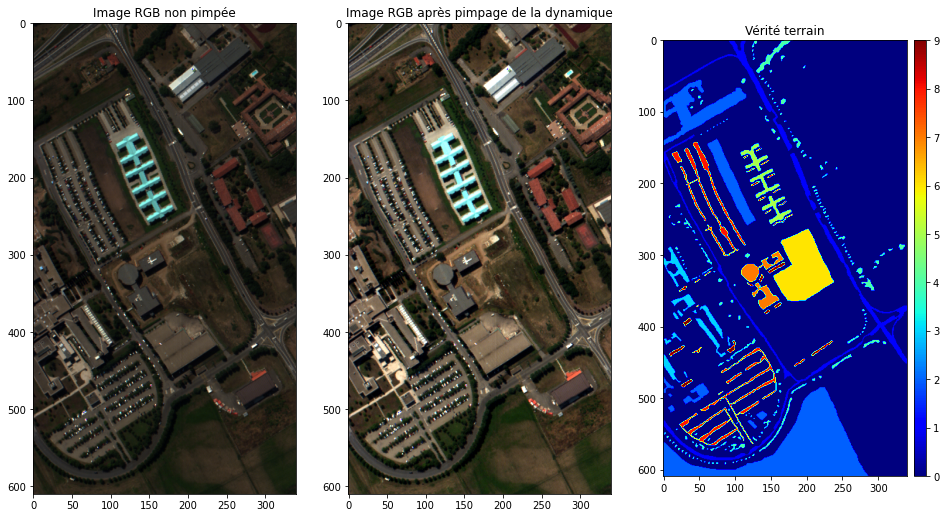

In [3]:
# Par convention, les bandes RGB de cette image sont R=47, G=26 et B=10
hsi_rgb = hsi[:,:,[47,26,10]]

# Réétalonne la dynamique de l'histogramme de chaque bande RGB (étire l'histogramme comprit entre 1% et 99%)
perc = 1
plow, phigh = np.percentile(hsi_rgb, (perc, 100-perc))
pimp_my_hsi_rgb = exposure.rescale_intensity(hsi_rgb, in_range=(plow, phigh))

# Affiche tout ce bazar
plt.figure(figsize=(16,16))
plt.subplot(131)
plt.title('Image RGB non pimpée')
plt.imshow(hsi_rgb)
plt.subplot(132)
plt.imshow(pimp_my_hsi_rgb)
plt.title('Image RGB après pimpage de la dynamique')
plt.subplot(133)
ax = plt.gca()
plt.title('Vérité terrain')
imgt = ax.imshow(gt,cmap='jet')
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.1)
plt.colorbar(imgt, cax=cax)
plt.show()

Pour la vérité terrain ci-dessus, chacune des 9 classes présentent dans l'image est identifiée par un label allant de $1$ à $9$ (la classe $0£ étant, par convention, le fond de l'image). La correspondance des labels avec leur classe sémantique est donné ci-dessous

| label | classe |
|  ---  |   ---  | 
| 1 | Asphalte |
| 2 | Champ/herbe |
| 3 | Gravier |
| 4 | Végétation |
| 5 | Plaques de métal peintes |
| 6 | Sol nu|
| 7 | Bitume |
| 8 | Briques autobloquantes |
| 9 | Ombre |

Plutôt que d'utiliser un algorithme d'induction aveugle d'endmembers ou une bibliothèque spectrale, on va se servir de la vérité terrain pour construire la matrice d'endmembers $\mathbf{E}$.

On va cependant exclure la classe "ombre", qui ne peut pas être considéré comme un constituant macroscopique pur. Pour les classes de $1$ à $8$, on va définir la signature spectral de l'endmember correspondant comme étant le médoïde de tous les pixels appartenant à la classe.

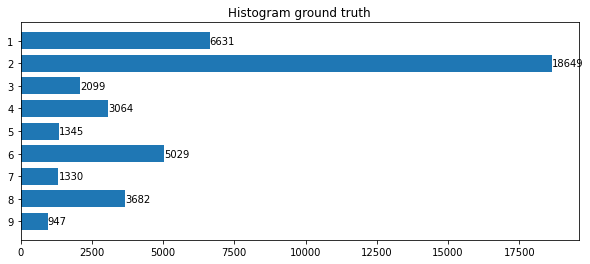

In [4]:
fig, axs = plt.subplots(figsize=(10, 4))

bar_x, bar_count = np.unique(gt[gt != 0], return_counts=True)
bar = axs.barh(bar_x, bar_count, 0.75)

axs.bar_label(bar)

axs.set_yticks(np.arange(len(bar_x)) + 1)
axs.invert_yaxis() 

axs.set_title('Histogram ground truth')
plt.show()

Pour mieux connaitre la répartition des nos classes, nous avons décidé d'afficher l'histogramme correspondant. Nous pouvons remarquer que la classe 2 est la plus présente.

**1.1) Quelle est la différence principale entre le centroïde et le médoïde d'un ensemble de points ? Quel est le principal avantage du médoïde par rapport au centroïde ?**

Les médoïdes sont des points du jeu de données alors que les centroïdes sont des points estimés (centre de gravité).

Les médoïdes sont plus robustes au bruit et aux anomalies statistiques.

L'algorithme de calcul du médoïde d'un ensemble de points est donné ci-dessous (il n'est pas nécessaire d'essayer de le comprendre)

In [5]:
# vecteur médoïde xmed de X [Nsamples,Nfeatures]
# (pompé sans aucune honte quelque part sur le net)
def geometric_median(X, eps=1e-5):
    y = np.mean(X, 0)

    while True:
        D = sp.spatial.distance.cdist(X, [y])
        nonzeros = (D != 0)[:, 0]

        Dinv = 1 / D[nonzeros]
        Dinvs = np.sum(Dinv)
        W = Dinv / Dinvs
        T = np.sum(W * X[nonzeros], 0)

        num_zeros = len(X) - np.sum(nonzeros)
        if num_zeros == 0:
            y1 = T
        elif num_zeros == len(X):
            return y
        else:
            R = (T - y) * Dinvs
            r = np.linalg.norm(R)
            rinv = 0 if r == 0 else num_zeros/r
            y1 = max(0, 1-rinv)*T + min(1, rinv)*y

        if sp.spatial.distance.euclidean(y, y1) < eps:
            return y1

        y = y1

On peut donc constituer la matrice d'endmembers $\mathbf{E} \in \mathbb{R}^{N_{bands} \times m}$, en récupérant le médoïde de chacune des $m=8$ premières classes de la vérité terrain. $N_{bands}$ étant évidemment le nombre de bandes dans l'image hyperspectrale

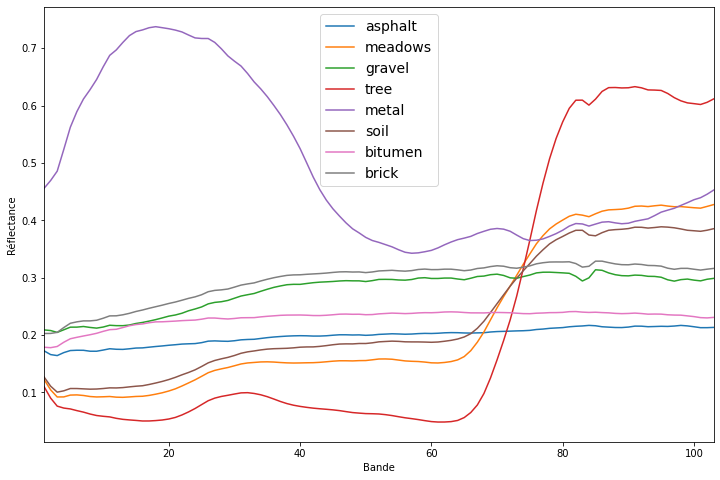

In [6]:
# liste des noms des constituants macroscopiques
endmembers = ['asphalt','meadows','gravel','tree','metal','soil','bitumen','brick']
# m => nombre total d'endmembers considérés
m = len(endmembers)
# E => matrice Nbands x m
E = np.zeros((Nbands,m))
# vectorisation du cube 3D (Nrow x Ncol x Nbands) en matrice (Npix x Nbands)
hsir = hsi.reshape(Npix,Nbands)
# extraction du médoïde pour chaque classe
for c in range(1,m+1): # indice des classes commençant à 1
    class_idx = (gt==c).ravel() # indices vectorisé des pixels appartenant à la classe c
    all_spectra = hsir[class_idx,:] # récupération des spectres correspondants (lignes de la matrice hsir)
    E[:,c-1] = geometric_median(all_spectra) # calcul du médoïde et stockage dans E
    
# On affice les signatures spectrales des 8 endmembers
plt.figure(figsize=(12,8))
for m,em in enumerate(endmembers):
    plt.plot(np.arange(1,104),E[:,m],label=em)
plt.xlim((1,103))
plt.xlabel('Bande')
plt.ylabel('Réflectance')
plt.legend(loc='best',fontsize=14)
plt.show()

## II. Démélange par moindres carrés ordinaires

On attaque maintenant le vif du sujet. Étant donnés la matrice d'endmembers $\mathbf{E} = [\mathbf{e}_1,\dots,\mathbf{e}_m] \in \mathbb{R}^{N_{bands} \times m}$ et le spectre $\mathbf{x} \in \mathbb{R}^{N_{bands}}$ d'un pixel, on veut récupérer les abondances fractionnelles $\boldsymbol \phi = [\phi_1,\dots,\phi_m]$ de $\mathbf{x}$.

D'après le LMM, $\mathbf{x}$ s'écrit comme la combinaison linéaire des endmembers $\mathbf{e}_i$ pondérés par leur abondance fractionnelle $\phi_i$ correspondante (plus un bruit additif indépendant pour modéliser les imprefections du modèle) :
$$ \mathbf{x} = \sum_{i=1}^m \phi_i \mathbf{e}_i + \boldsymbol \eta = \mathbf{E} \boldsymbol \phi + \eta$$

L'inversion de ce modèle revient à calculer le vecteur $\boldsymbol \phi$ qui minimise la _residual sum of squares_ $RSS(\boldsymbol \phi) = \displaystyle \sum_{i=1}^{N_{bands}} \big(x(i) - [\mathbf{E}\boldsymbol \phi](i)\big)^2 = \|\mathbf{x} -  \mathbf{E}\boldsymbol \phi \|_2^2$ :

$$ \boldsymbol \phi = \arg\min_{\boldsymbol \phi \in \mathbb{R}^m} = \|\mathbf{x} -  \mathbf{E}\boldsymbol \phi \|_2^2 \quad (1)$$

**2.1) Retrouver analytiquement la solution du problème (1).**

Il s'agira d'exprimer $\boldsymbol \phi$ en fonction de $\mathbf{E}$ et $\mathbf{x}$.

Vous devez coder la solution analytique vous même dans un premier temps. Ce n'est que dans un second temps que vous pourrez vous rassurer (ou pas) en vérifiant que vous obtenez bien la même chose qu'un solveur de moindres carrés ordinaires.

Démélangez dans un premier temps des spectres appartenant à l'une des 8 classes.

On pose $f(\phi) = RSS(\phi) = \lVert x-E\phi \rVert_2^2$.\
Pour minimiser $f$, on cherche à résoudre $\nabla(f) = \vec{0}$.\
\begin{align*}
    f(\phi) &= \lVert x - E\phi \rVert_2^2\\
    &= (x-E\phi)^T(x-E\phi)\\
    &= x^Tx - x^TE\phi - \phi^TE^Tx + \phi^TE^TE\phi
\end{align*}

* $g(\phi) = x^TE\phi$\
$g(\phi + h) = x^TE\phi + x^TEh$\
On obtient $\nabla(g)^T = x^TE = (E^Tx)^T$\
Donc $\nabla(g) = E^Tx$

    
* $g(\phi) = \phi^TE^T\phi$\
$g(\phi + h) = (\phi+h)^TE^Tx = \phi^TE^Tx+h^TE^Tx$\
On obtient $\nabla(g) = E^Tx$


* $g(\phi) = \phi^TE^TE\phi$\
$g(\phi+h) = \phi^TE^TE\phi + \phi^TE^TEh + h^TE^TE\phi + h^TE^TEh$\
On obtient $\nabla(g) = E^TE\phi + (\phi^TE^TE)^T = 2E^TE\phi$

On réinjecte dans $\nabla(f) = \vec{0}$ pour retrouver l'équation normale.
\begin{align*}
    \nabla(f) = \vec{0} \quad &\iff \quad -E^Tx - E^Tx + 2E^TE\phi = 0\\
    &\iff \quad E^TE\phi = E^Tx\\
    &\iff \quad \phi = (E^TE)^{-1}E^Tx
\end{align*}

In [7]:
def analytic_solution(E, x):
    return np.linalg.inv(E.T @ E) @ E.T @ x

**2.2) En théorie, quelle devrait être la composition du vecteur d'abondances $\boldsymbol \phi$? Et qu'en est-il en pratique ? Comparez graphiquement le spectre initial $\mathbf{x}$ avec sa reconstruction $\hat{\mathbf{x}} = \mathbf{E}\boldsymbol \phi$**

En théorie, $\boldsymbol \phi$ devrait être composée de valeurs comprises entre 0 et 1 pour chaque pixel et chaque endmember, car ce sont des probabilités. Par conséquent, pour chaque pixel, la somme des éléments de $\boldsymbol \phi$ devrait être égale à 1.

En pratique, ce n'est pas le cas, car dans notre modèle nous n'avons pas appliqué de contraintes.

In [8]:
gt_flatten = gt.flatten()

In [9]:
# Get 0 and 0 classes indexes
usefull_idx = np.where((gt_flatten != 0) & (gt_flatten != 9))[0]

In [10]:
# Remove 0 and 9 classes
hsi_usefull = hsi.reshape((-1, 103))[usefull_idx]
gt_usefull = gt_flatten[usefull_idx]

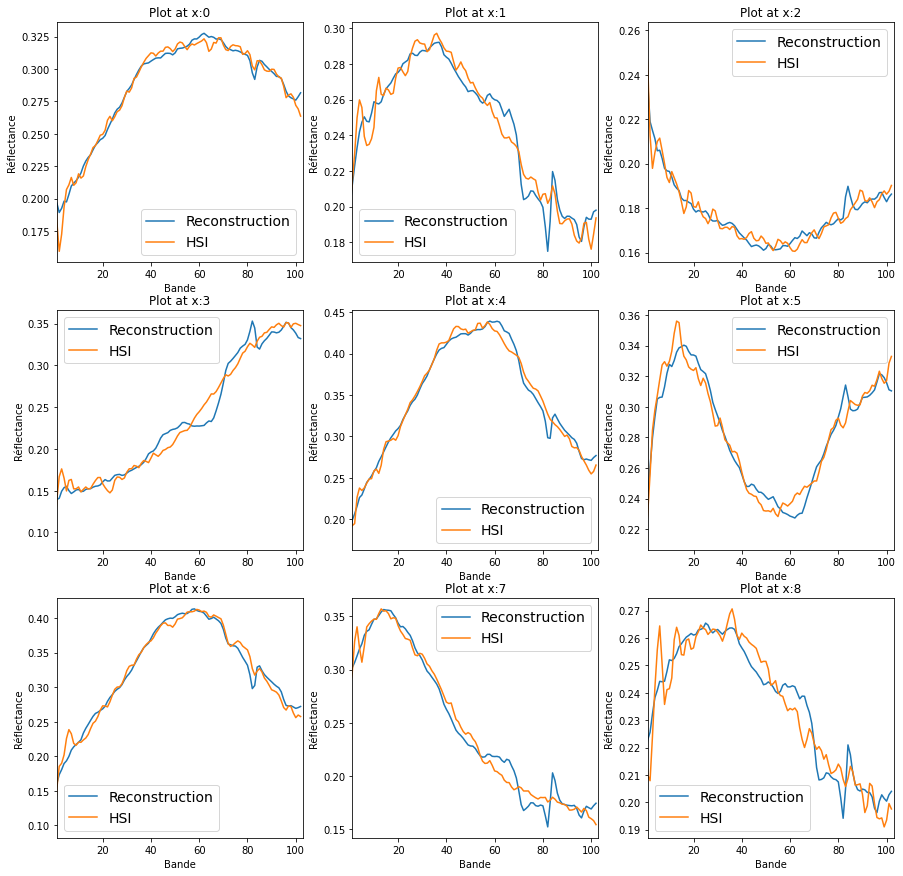

In [11]:
plt.figure(figsize=(15,15))

for i in range(9):
    x = hsi_usefull[i]
    x_hat = E @ analytic_solution(E, x)
    
    plt.subplot(3, 3, i + 1)
    plt.plot(x_hat, label='Reconstruction')
    plt.plot(x, label='HSI')
    plt.title("Plot at x:{}".format(i))
    plt.xlim((1,103))
    plt.xlabel('Bande')
    plt.ylabel('Réflectance')
    plt.legend(loc='best',fontsize=14)
plt.show()

On peut constater que les deux courbes sont très proches et l'écart entre les deux est faible. On peut donc noter que notre estimation est plutôt bonne et les données sont bien reconstruites.

Il est coutûme de mesurer quantitativement la qualité de démélange de $\mathbf{x}$ par l'erreur quadratique moyenne entre $\mathbf{x}$ et sa reconstruction $\mathbf{\hat{x}} = \sum_{i=1}^m \phi_i \mathbf{e}_i$ :

$$\epsilon(\mathbf{x},\mathbf{\hat{x}}) = \sqrt{\frac{1}{N_{bands}} \sum_{i=1}^{N_{bands}} (x(i) - \hat{x}(i))^2} \quad (2)$$

**2.3) Implémentez la fonction d'erreur quadratique moyenne. Quel ordre de grandeur obtenez vous pour les spectres démélangées précédemment ?**

In [12]:
def mean_square_error(x, x_hat):
    s_diff = (x - x_hat) ** 2
    if len(x.shape) == 1:
        return np.sqrt(np.mean(s_diff))
    else:
        return np.sqrt(np.mean(s_diff, axis=1))

In [13]:
# Compute MSE for first 9 values
for i in range(9):
    x = hsi_usefull[i]
    x_hat = E @ analytic_solution(E, x)
    print("MSE at ({}): {}".format(i, mean_square_error(x, x_hat)))

MSE at (0): 0.007252513995219739
MSE at (1): 0.008593854097406565
MSE at (2): 0.004188427916785423
MSE at (3): 0.014517409523267777
MSE at (4): 0.00940742544436995
MSE at (5): 0.009190774743458396
MSE at (6): 0.010806094051795905
MSE at (7): 0.010248537061416109
MSE at (8): 0.007545169128888069


On peut constater que pour les premières valeurs nous obtenons une erreur quadratique moyenne d'au plus 0.015 ce qui est assez faible. Cependant, il serait plus judicieux de calculer la moyenne des erreurs quadratiques.

In [14]:
# Compute MSE for all values
mses = np.empty((hsi_usefull.shape[0]))
for i in range(hsi_usefull.shape[0]):
    x = hsi_usefull[i]
    x_hat = E @ analytic_solution(E, x)
    mses[i] = mean_square_error(x, x_hat)
        
mses.mean() # Moyenne des erreurs quadratiques moyennes de tous les pixels de l'image

0.006456906105144761

En calculant la moyenne des erreurs, nous obtenons 0.0065.

L'ordre de grandeur des erreurs est au centième près. Notre modèle est plutôt bon sur les données d'entrainements. 

Démélanger pixel par pixel, c'est bien. Mais s'il était possible d'obtenir d'un coup les abondances fractionnelles de tous les pixels de l'image, ça serait vachement mieux. Et ça tombe bien, car c'est possible : il suffit d'utiliser la modélisation matricielle de l'image hyperspectrale $\mathbf{X} \in \mathbb{R}^{N_{bands} \times N_{pix}}$ et d'étendre le problème (1) sous la forme 

$$\boldsymbol \Phi = \arg\min_{\Phi \in \mathbb{R}^{m\times N_{pix}}} = \|\mathbf{X} -  \mathbf{E}\Phi \|_2^2 \quad (1)$$

La solution $\boldsymbol \Phi \in \mathbb{R}^{m\times N_{pix}}$ obtenue s'interprète donc comme une matrice d'abondances fractionnelles, où chaque colonne contient le vecteur d'abondance $\boldsymbol \phi$ du pixel correspondant. Cette matrice peut se réorganiser à moindres frais en un cube 3D $(N_{row} \times N_{col} \times m)$, où chaque canal peut se visualiser comme la carte d'abondances fractionelles de l'image entière pour l'endmember considéré.

**2.4) Adaptez votre implémentation de la question 2) pour obtenir la matrice d'abondance $\boldsymbol \Phi$ en un coup**

In [15]:
phi = analytic_solution(E, hsi_usefull.T)
x_hat = E @ phi

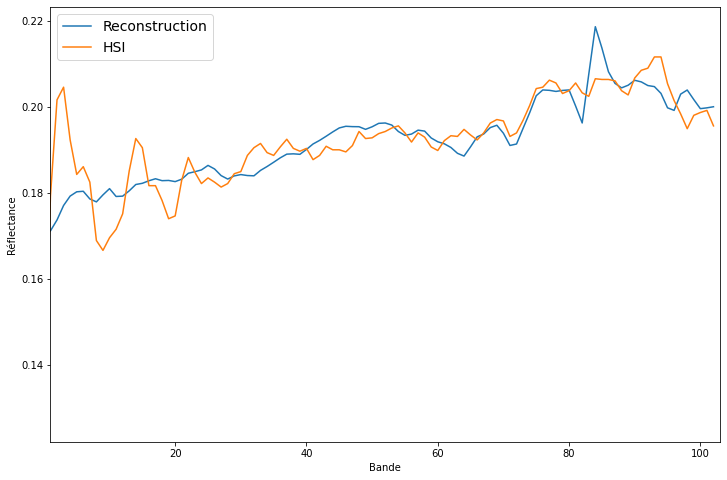

In [16]:
plt.figure(figsize=(12,8))
plt.plot(x_hat[:, 12], label='Reconstruction')
plt.plot(hsi_usefull[12, :], label='HSI')
plt.xlim((1,103))
plt.xlabel('Bande')
plt.ylabel('Réflectance')
plt.legend(loc='best',fontsize=14)
plt.show()

**2.5) Réorganisez la matrice précédente en un cube 3D et visualisez les différentes cartes d'abondances pour les 8 endmembers. Que remarquez vous/pouvez vous en conclure ?**

In [17]:
# Build entire phi
full_phi = np.zeros((Nrow * Ncol, 8))
full_phi[usefull_idx] = phi.T
full_phi = full_phi.reshape((Nrow, Ncol, 8))

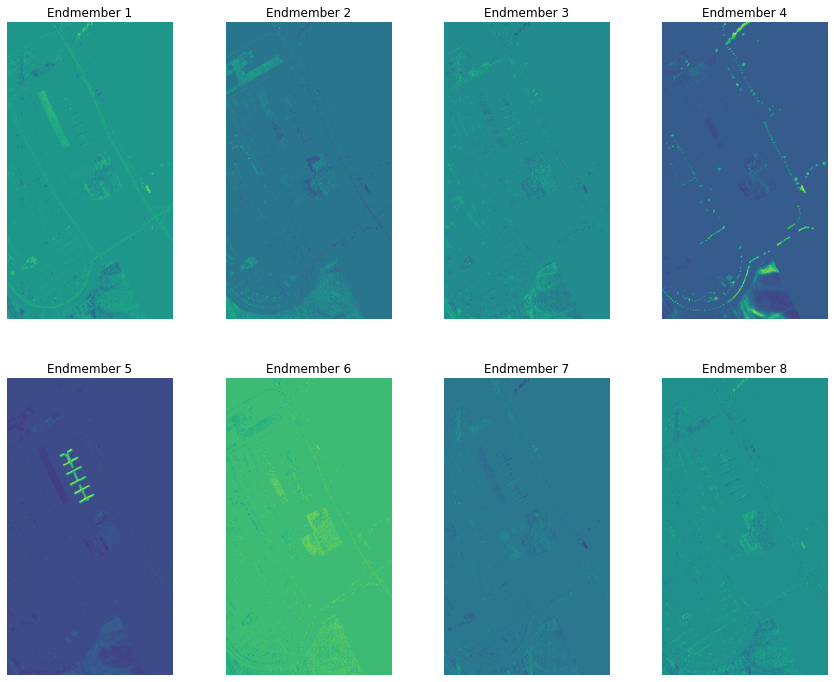

In [18]:
# Display abondance map for each endmembers
plt.figure(figsize=(15,12))

for i in range(8):
    plt.subplot(2, 4, i + 1)
    plt.title('Endmember {}'.format(i + 1))
    plt.imshow(full_phi[:, :, i])
    plt.axis('off')
    
plt.show()

Nous pouvons remarquer que les differentes cartes d'abondances apportent des informations differentes sur l'image. Par exemple, sur la carte d'abondance numero 5 on observe un motif que l'on ne retrouve pas sur les autres cartes, à savoir un motif qui correspond aux plaques de métales peintes. 

Tout comme l'équation (1) peut se reformuler pour obtenir une solution matricielle (la matrice $\boldsymbol \Phi$), il est possible d'obtenir d'un coup l'erreur quadratique moyenne de l'image entière $\epsilon(\mathbf{X},\mathbf{\hat{X}} = \mathbf{E}\boldsymbol \Phi)$ (plutôt que de boucler sur tous les pixels).

**2.6) Visualisez la carte d'erreur quadratique moyenne de l'image hyperspectral pour le démélange obtenu**

In [19]:
x_hat = E @ analytic_solution(E, hsi_usefull.T)
mses = mean_square_error(hsi_usefull, x_hat.T)

In [20]:
# Build image from errors
full_mses = np.zeros((Nrow * Ncol))
full_mses[usefull_idx] = mses
full_mses = full_mses.reshape((Nrow, Ncol))

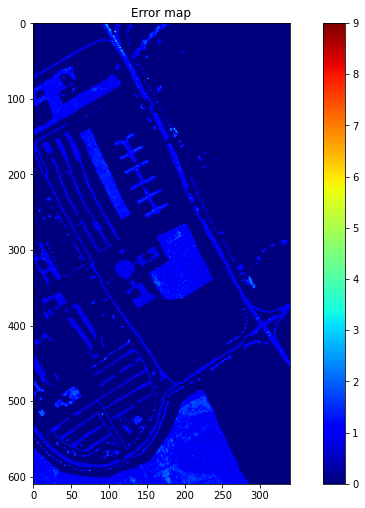

In [21]:
plt.figure(figsize=(12, 8))
plt.imshow(full_mses, cmap='jet')
plt.title('Error map')
plt.subplots_adjust(bottom=0.1, right=0.8, top=0.9)
cax = plt.axes([0.65, 0.1, 0.025, 0.8])
plt.colorbar(imgt, cax=cax)
plt.show()

Ci-dessus, nous avons affiché la carte d'erreurs et nous pouvons constater que l'erreur commise est très faible. En effet, tous les pixels apparaissent bleus. Nous pouvons également afficher les valeurs minimales et maximales de nos erreurs.

In [22]:
print('Min error: {}'.format(mses.min()))
print('Max error: {}'.format(mses.max()))

Min error: 0.002463964951865826
Max error: 0.054047382920308806


On peut imaginer une stratégie de classification naïve : chaque pixel est classifié selon son abondance fractionnelle majoritaire (puisqu'en théorie, plus l'abondance fractionelle est proche de $1$, plus le matériau correspondant est présent dans la signature spectrale du pixel en question). Même si le démélange obtenu précédemment avec les moindres carrés ordinaires devrait laisser à penser que cette stratégie est vouée à l'échec, on peut quand même y jeter un oeil.

Elle pourrait avoir particulièrement du sens pour les pixels supposés "purs", c'est à dire tous les pixels de la vérité terrain dont le label est compris entre $1$ et $8$ (les pixels labelisés $0$ sont de classe inconnue du point de vue de la classification, et les pixels labelisés $9$ correspondant à de l'ombre (d'un autre matériau), ils ne sont pas purs non plus).

**2.7) Appliquez la stratégie de classification évoquée juste au dessus, à savoir que chaque pixel est classifié selon son abondance fractionnelle majoritaire, et visualisez la carte de classification obtenue. Que pouvez vous en conclure ?**

In [23]:
classifier = np.argmax(phi, axis=0) + 1

# Build image with the strategy
full_classifier = np.zeros((Nrow * Ncol))
full_classifier[usefull_idx] = classifier
full_classifier = full_classifier.reshape((Nrow, Ncol))

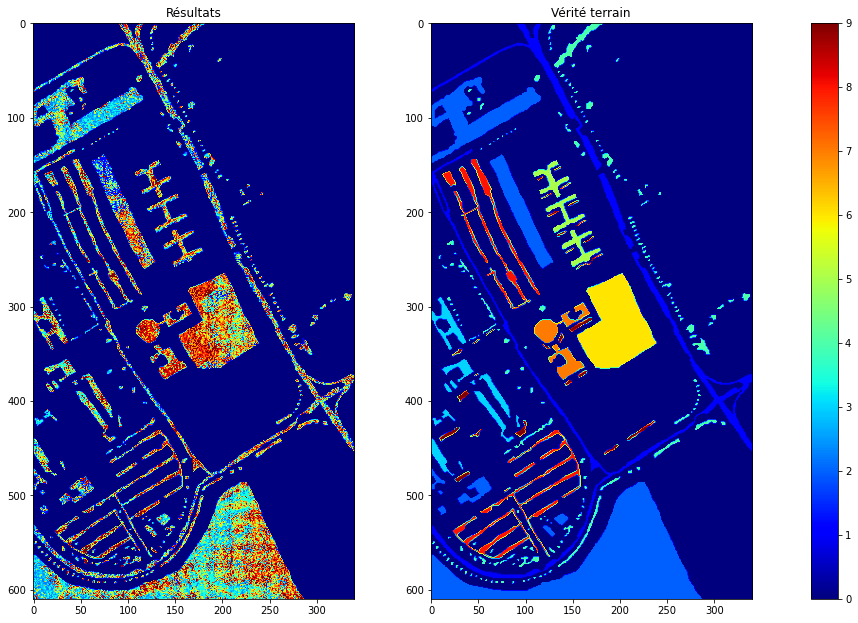

In [24]:
plt.figure(figsize=(15, 10))

plt.subplot(1, 2, 1)
plt.imshow(full_classifier, cmap='jet')
plt.title('Résultats')

plt.subplot(1, 2, 2)
plt.imshow(gt, cmap='jet')
plt.title('Vérité terrain')

plt.subplots_adjust(bottom=0.1, right=0.8, top=0.9)
cax = plt.axes([0.85, 0.1, 0.025, 0.8])
plt.colorbar(imgt, cax=cax)

plt.show()

On cherche à résoudre un problème qui nécessite d'avoir des contraintes pour que le modèle fonctionne correctement. Cependant, on ne les considère pas pour le moment, ce qui nous amène à un résultat décevant.

L'évaluation qualitative précédente permet de donner des billes sur ce qui marche et ce qui ne marche pas à propos de la stratégie de classification appliquée. Mais cette évaluation qualitative doit être complétée par une évaluation quantitative plus rigoureuse, par le biais des métriques classiques de classification que vous connaissez.

**2.8) Complétez votre analyse précédente par une évaluation quantitative : taux de bonne classification globale, matrice de confusion et taux de bonne classification par classe**

In [25]:
def plot_confusion_matrix(labels, preds, class_names, title='Confusion matrix', log=False):
    '''
    Plot the confusion matrix
    params
    ----------
    labels: Labels array of shape (n_samples,)
    preds: Predictions array of shape (n_samples,)
    class_names: Names of the different classes
    title: Title of the plot
    log: Logarithm plot
    '''
    # Plot confusion matrix using log / linear scale

    # Get confusion matrix and skip background (label 0)
    matrix = confusion_matrix(labels.flatten(), preds.flatten())

    df = pd.DataFrame({class_names[i]:matrix[:,i] for i in range(len(class_names))}, index=class_names)
    fig = plt.figure(figsize = (10,6))
    ax = fig.add_subplot()
    ax.xaxis.set_ticks_position('top')
    if log:
        sn.heatmap(df, annot=True, cmap="OrRd", fmt='g', norm=LogNorm())
    else:
        sn.heatmap(df, annot=True, cmap="OrRd", fmt='g')

    plt.title(title)
    plt.show()

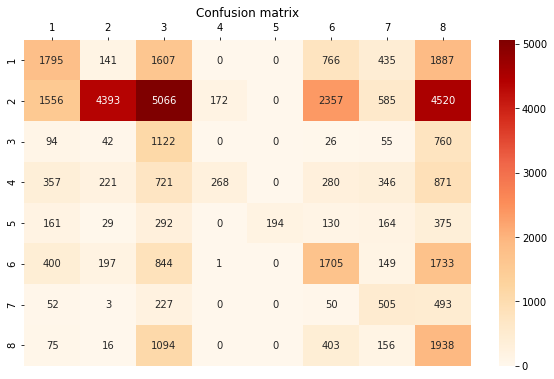

In [26]:
plot_confusion_matrix(gt_usefull, full_classifier[full_classifier != 0], class_names=np.arange(1, 9), log=False)

Nous pouvons remarquer que la diagonale de la matrice n'est pas mise en avant. Cela signifie que notre classification commet de nombreuses erreurs. 

In [27]:
print(classification_report(gt_usefull, full_classifier[full_classifier != 0]))

              precision    recall  f1-score   support

           1       0.40      0.27      0.32      6631
           2       0.87      0.24      0.37     18649
           3       0.10      0.53      0.17      2099
           4       0.61      0.09      0.15      3064
           5       1.00      0.14      0.25      1345
           6       0.30      0.34      0.32      5029
           7       0.21      0.38      0.27      1330
           8       0.15      0.53      0.24      3682

    accuracy                           0.28     41829
   macro avg       0.46      0.31      0.26     41829
weighted avg       0.59      0.28      0.31     41829



Nous avons décidé d'afficher le rapport de classification afin de pouvoir analyser les métriques pour chaque classe.

Nous pouvons remarquer que la precision de la classe 5 est de 1.0 mais le recall et le f1-score de cette même classe sont faibles ce qui signifie qu'il y a beaucoup de faux négatifs.

La précision (accuracy) moyenne de notre classification est seulement de 0.28 d'où le fait que nos résultats sont décevants.

## III. Régularisation de Tikhonov

Les techniques de régularisation sont très souvent utilisés pour la résolution de problèmes mal posés. Pour des problèmes linéaires sur-déterminés, c'est à dire du type $\mathbf{A}\mathbf{x} = \mathbf{b}$, où la matrice $\mathbf{A}$ possède plus de lignes que de colonnes - c'est notre cas ici - la régularisation va se matérialiser comme l'ajout d'un second terme $\mathcal{R}(\mathbf{x})$ au $RSS(\mathbf{x}) = \| \mathbf{A}\mathbf{x} - \mathbf{b}\|_2^2 $ :

$$ RSS \text{ avec régularisation : }  \| \mathbf{A}\mathbf{x} - \mathbf{b}\|_2^2 + \mathcal{R}(\mathbf{x}), \quad (3)$$

de manière à ce que la solution de ce problème d'optimisation retrouver des propriétés souhaitables (de stabilité par exemple, c'est-à-dire qu'une légère perturbation de l'entrée n'entraine qu'une légère perturbation de la sortie, ce qui n'est pas le cas sans régularisation si $\mathbf{A}$ est mal conditionnée.

Le choix du terme de régularisation $\mathcal{R}(\mathbf{x})$ va bien sûr influer sur ces propriétés et sur la manière de résoudre le problème (3).

Dans le cas de la régularisation de Tikhonov, le terme de régularisation (aussi appelé _pénalité_) s'exprime comme $\mathcal{R}(\mathbf{x}) = \lambda \| \boldsymbol \Gamma \mathbf{x}\|_2^2$, où $\boldsymbol \Gamma$ (appelé matrice de Tikhonov) est déterminé en fonction du problème, et où $\lambda$ permet de donner plus où moins de poids à la régularisation par rapport au RSS.

Dans notre cas de démélange, $\boldsymbol \Gamma$ sera choisi comme la matrice identité, de manière à ce qu'on puisse réécrire le problème d'optimisation (en reprenant nos notations précédentes) : 

$$ \arg\min_{\boldsymbol \phi \in \mathbb{R}^m} = \|\mathbf{x} -  \mathbf{E}\boldsymbol \phi \|_2^2 + \lambda \|\boldsymbol \phi \|_2^2\quad (4)$$

Ainsi, le terme de régularisation, en pénalisant les solutions ayant des composantes importantes (en valeur absolue), aura tendance à privilégier des solutions $\boldsymbol \phi$ dont la norme euclidienne est faible. La valeure de $\lambda$ permettra de jouer sur le degré de régularisation (et donc la liberté qu'aura $\boldsymbol \phi$ d'avoir des entrées de magnitude élevée) : plus $\lambda$ sera élevé, et plus la régularisation sera importante.

Sans surprise, le but de cette partie va être d'étudier l'influence de la régularisation de Tikhonov sur le problème d'estimation des abondances, et la comparaison avec la méthode des moindres carrés ordinaires. IL s'agira donc ici de reproduire ce qui a été fait dans la partie II, tout en intégrant l'étude de l'influence de $\lambda$ sur la qualité du démélange

**3.1) Dérivez sur papier la solution analytique du problème (4)** (car oui, elle existe, et elle est pas tellement plus compliquée que la solution des moindres carrés ordinaires)

On pose $f(\phi) = RSS(\phi) = \lVert x-E\phi \rVert_2^2 + \lambda \left \| \phi \right \|_{2}^{2}$.\
Pour minimiser $f$, on cherche à résoudre $\nabla(f) = \vec{0}$.\
\begin{align*}
    f(\phi) &= \lVert x - E\phi \rVert_2^2 + \lambda \left \| \phi \right \|_{2}^{2}\\
    &= (x-E\phi)^T(x-E\phi) + \lambda \phi^T\phi\\
    &= x^Tx - x^TE\phi - \phi^TE^Tx + \phi^TE^TE\phi + \lambda \phi^T\phi
\end{align*}

* $g(\phi) = x^TE\phi$\
$g(\phi + h) = x^TE\phi + x^TEh$\
On obtient $\nabla(g)^T = x^TE = (E^Tx)^T$\
Donc $\nabla(g) = E^Tx$

    
* $g(\phi) = \phi^TE^T\phi$\
$g(\phi + h) = (\phi+h)^TE^Tx = \phi^TE^Tx+h^TE^Tx$\
On obtient $\nabla(g) = E^Tx$


* $g(\phi) = \phi^TE^TE\phi$\
$g(\phi+h) = \phi^TE^TE\phi + \phi^TE^TEh + h^TE^TE\phi + h^TE^TEh$\
On obtient $\nabla(g) = E^TE\phi + (\phi^TE^TE)^T = 2E^TE\phi$


* $g(\phi) = \lambda \phi^T\phi$\
$g(\phi + h) = \lambda (\phi + h)^T(\phi + h)$\
$g(\phi + h) = \lambda \phi^T\phi + \lambda 2 \phi^Th + \lambda h^T h$\
On obtient $\nabla(g) = \lambda 2 \phi$

On réinjecte dans $\nabla(f) = \vec{0}$ pour retrouver l'équation normale.
\begin{align*}
    \nabla(f) = \vec{0} \quad &\iff \quad -E^Tx - E^Tx + 2E^TE\phi + \lambda 2 \phi = 0\\
    &\iff \quad (E^TE + \lambda I)\phi = E^Tx\\
    &\iff \quad \phi = (E^TE + \lambda I)^{-1}E^Tx
\end{align*}

In [28]:
def analytic_solution_tikhonov(E, x, l):
    return np.linalg.inv(E.T @ E + l * np.identity(E.shape[1])) @ E.T @ x

**3.2) Implémentez le démélange avec régularisation de Tikhonov pour quelques spectres de l'image. Que remarquez vous qualitativement (comparaison de la signature originelle $\mathbf{x}$ avec la signature reconstruite) et quantitativement (valeur de l'erreur quadratique moyenne) par rapport aux solutions obtenues par moindres carrés ordinaires ? L'influence de $\lambda$ est elle bien conforme à celle prédite par la théorie ?**

In [29]:
x_moindres = E @ analytic_solution(E, hsi_usefull.T)
x_tikhonov = E @ analytic_solution_tikhonov(E, hsi_usefull.T, 0.008)

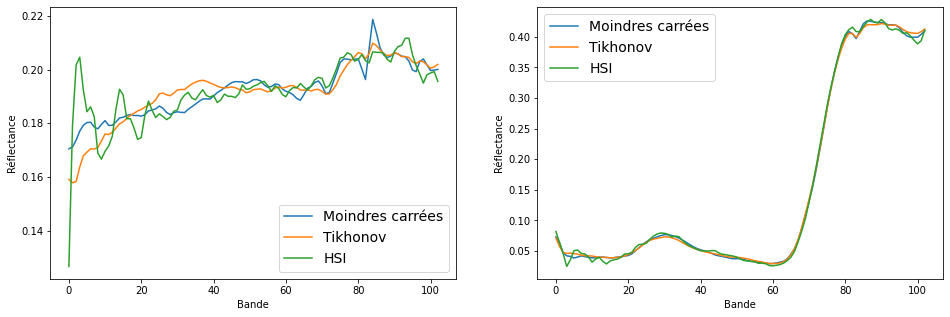

In [30]:
plt.figure(figsize=(16,5))

plt.subplot(1, 2, 1)
plt.plot(x_moindres[:, 12], label='Moindres carrées')
plt.plot(x_tikhonov[:, 12], label='Tikhonov')
plt.plot(hsi_usefull[12, :], label='HSI')
plt.xlabel('Bande')
plt.ylabel('Réflectance')
plt.legend(loc='best',fontsize=14)

plt.subplot(1, 2, 2)
plt.plot(x_moindres[:, 24], label='Moindres carrées')
plt.plot(x_tikhonov[:, 24], label='Tikhonov')
plt.plot(hsi_usefull[24, :], label='HSI')
plt.xlabel('Bande')
plt.ylabel('Réflectance')
plt.legend(loc='best',fontsize=14)

plt.show()

Nous pouvons remarquer qu'avec la régularisation de Tikhonov, les courbes obtenues sont proches de celles attendues.

In [31]:
mses_moindres = mean_square_error(hsi_usefull, x_moindres.T)
mses_tikhonov = mean_square_error(hsi_usefull, x_tikhonov.T)

In [32]:
print('Mean MSES moindres carrées: {}'.format(np.mean(mses_moindres)))
print('Mean MSES Tikhonov: {}'.format(np.mean(mses_tikhonov)))

Mean MSES moindres carrées: 0.006456906105144761
Mean MSES Tikhonov: 0.008724928563866426


L'erreur moyenne obtenue avec régularisation Tikhonov est de 0.0087 alors que celle avec la méthode des moindres carrées est de 0.0065. Bien que celle-ci soit plus importante, l'ordre de grandeur est toujours au centième.

In [33]:
# lambda influence
phi_list = []
lambdas = np.linspace(0, 0.01, 20)
for l in lambdas:
    phi_list.append(analytic_solution_tikhonov(E, hsi_usefull.reshape((-1, Nbands)).T, l))
    
phi_list = np.array(phi_list)

In [34]:
df = pd.DataFrame(columns=['Lambda', 'MSE'])
for i, l in enumerate(lambdas):
    df.loc[df.shape[0]] = [l, mean_square_error(E @ phi_list[i], hsi_usefull.reshape((-1, Nbands)).T)[0]]
    
display(df)

Lambda       MSE
0   0.000000  0.019692
1   0.000526  0.026321
2   0.001053  0.028116
3   0.001579  0.029431
4   0.002105  0.030485
5   0.002632  0.031361
6   0.003158  0.032103
7   0.003684  0.032742
8   0.004211  0.033299
9   0.004737  0.033789
10  0.005263  0.034225
11  0.005789  0.034614
12  0.006316  0.034965
13  0.006842  0.035283
14  0.007368  0.035572
15  0.007895  0.035837
16  0.008421  0.036080
17  0.008947  0.036305
18  0.009474  0.036513
19  0.010000  0.036706

In [35]:
df.min()

Lambda    0.000000
MSE       0.019692
dtype: float64

Comme $\Gamma = I_n$, alors les solutions dont les normes sont petites vont être favorisées (cf. Régularisation de Tikhonov — Wikipédia). On peut le remarquer car lorsque que lambda est petit, la MSE l'est d'autaut plus. La pratique est bien conforme à la théorie. Dans notre cas, l'erreur est minimale lorsque lambda est nulle.

**3.3) Vérifiez que vous retrouver bien la même solution que les solveurs classiques de ce problème de régularisation** (si vous voulez passer par une bibliothèque de *machine learning*, vous trouverez la solution du problème (4) sous son autre appelation, à savoir "régression Ridge").

In [36]:
# Our model
#hsi_reshaped = hsi.reshape((-1, 103))
phi = analytic_solution_tikhonov(E, hsi_usefull.T, 0.008)
reconstruction = E @ phi

reconstruction_img = np.zeros((Nrow * Ncol))
reconstruction_img[usefull_idx] = reconstruction[12]
reconstruction_img = reconstruction_img.reshape((Nrow, Ncol))

In [37]:
# Sklearn model
clf = Ridge(alpha=0.008, solver='svd', fit_intercept=False)
clf.fit(E, hsi_usefull.T)
reconstruction_sk = E @ clf.coef_.T

reconstruction_img_sk = np.zeros((Nrow * Ncol))
reconstruction_img_sk[usefull_idx] = reconstruction_sk[12]
reconstruction_img_sk = reconstruction_img_sk.reshape((Nrow, Ncol))

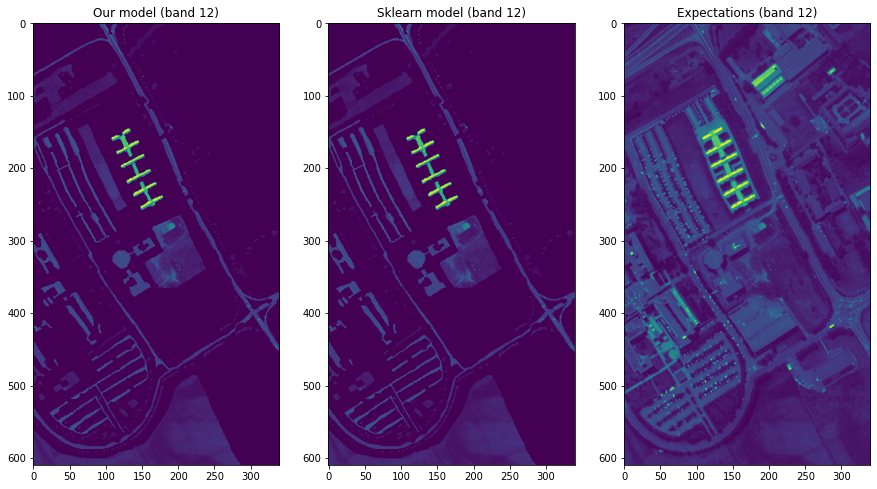

In [38]:
plt.figure(figsize=(15,12))

plt.subplot(1, 3, 1)
plt.title("Our model (band 12)")
plt.imshow(reconstruction_img)

plt.subplot(1, 3, 2)
plt.title("Sklearn model (band 12)")
plt.imshow(reconstruction_img_sk)

plt.subplot(1, 3, 3)
plt.title("Expectations (band 12)")
plt.imshow(hsi[:, :, 12])

plt.show()

Nous pouvons également noter que nous obtenons un résultat proche de celui de Ridge mais il est difficile de comparer visuellement ces deux images.

In [39]:
err = reconstruction_img - reconstruction_img_sk
print('Erreur moyenne: {}'.format(err.mean()))
print('Erreur maximale: {}'.format(err.max()))

Erreur moyenne: 6.8248646832945815e-15
Erreur maximale: 1.2512213487525514e-13


Nous pouvons remarquer que l'erreur maximale commise est de l'ordre de $1e^{-13}$ ce qui est très faible. Nous pouvons également noté que l'erreur moyenne est 100 fois plus petite. Nous pouvons donc affirmer que nous obtenons la même solution.

**3.4) Idem que pour les moindres carrés ordinaires, adaptez votre implémentation pour obtenir d'un coup la matrice d'abondances $\boldsymbol \Phi$ pour toute l'image. Affichez ces cartes d'abondances fractionnelles et la carte d'erreur quadratique moyenne de reconstruction pour l'image entière. Qu'en est-il de l'influence de $\lambda$ ?**

In [40]:
coefs = np.zeros((Nrow * Ncol, 8))
coefs[usefull_idx] = clf.coef_
coefs = coefs.reshape((Nrow, Ncol, 8))

In [41]:
full_phi = np.zeros((Nrow * Ncol, 8))
full_phi[usefull_idx] = phi.T
full_phi = full_phi.reshape((Nrow, Ncol, 8))

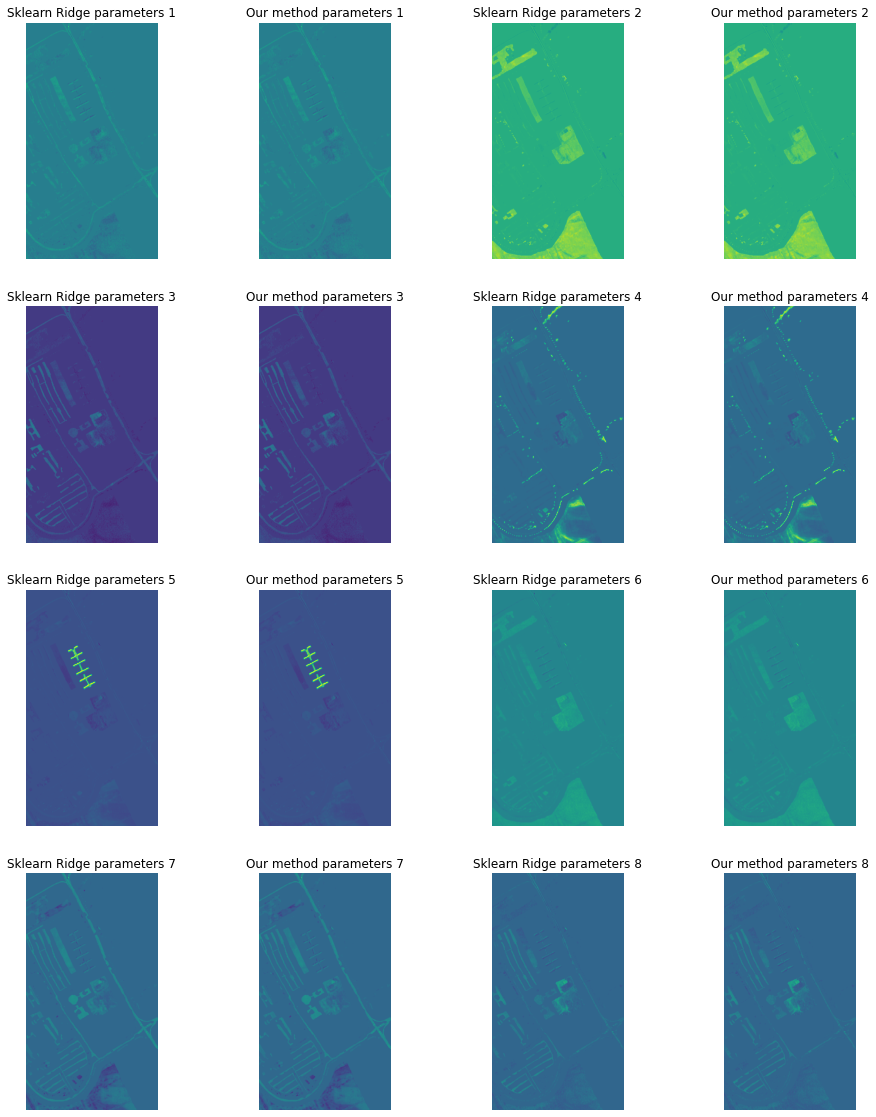

In [42]:
plt.figure(figsize=(16,20))

for i in range(8):
    plt.subplot(4, 4, 2 * i + 1)
    plt.title('Sklearn Ridge parameters {}'.format(i + 1))
    plt.imshow(coefs[:, :, i])
    plt.axis('off')
    
    plt.subplot(4, 4, 2 * i + 2)
    plt.title('Our method parameters {}'.format(i + 1))
    plt.imshow(full_phi[:, :, i])
    plt.axis('off')
    
plt.show()

En affichant les cartes d'abondances, nous pouvons noter que notre méthode nous permet d'avoir des résultats similaire à ceux de Ridge (de Sklearn). Nous parvenons à retrouver les mêmes motifs dans chaque carte.

In [43]:
phi_tikhonov = analytic_solution_tikhonov(E, hsi_usefull.T, 0.008)
x_tikhonov = E @ phi_tikhonov
mses = mean_square_error(hsi_usefull, x_tikhonov.T)

phi_tikhonov2 = analytic_solution_tikhonov(E, hsi_usefull.T, 1)
x_tikhonov2 = E @ phi_tikhonov2
mses2 = mean_square_error(hsi_usefull, x_tikhonov2.T)

phi_tikhonov3 = analytic_solution_tikhonov(E, hsi_usefull.T, 5)
x_tikhonov3 = E @ phi_tikhonov3
mses3 = mean_square_error(hsi_usefull, x_tikhonov3.T)

In [44]:
full_mses = np.zeros((Nrow * Ncol))
full_mses[usefull_idx] = mses
full_mses = full_mses.reshape((Nrow, Ncol))

full_mses2 = np.zeros((Nrow * Ncol))
full_mses2[usefull_idx] = mses2
full_mses2 = full_mses2.reshape((Nrow, Ncol))

full_mses3 = np.zeros((Nrow * Ncol))
full_mses3[usefull_idx] = mses3
full_mses3 = full_mses3.reshape((Nrow, Ncol))

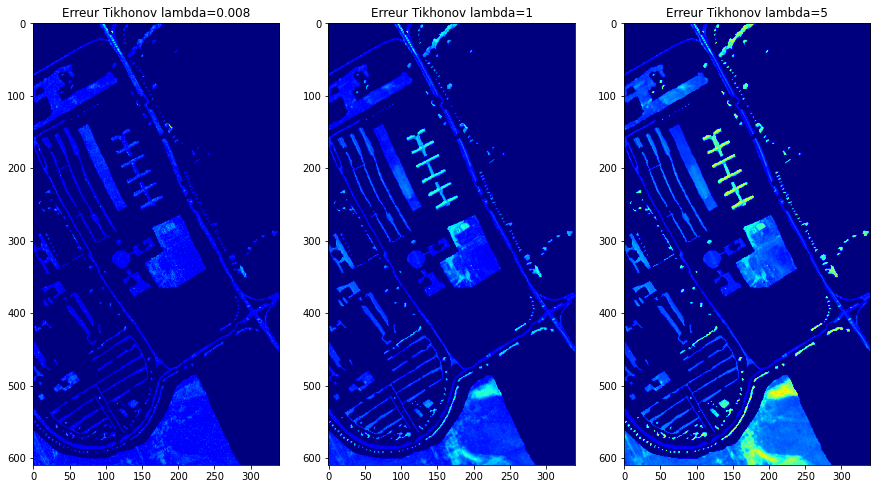

In [45]:
plt.figure(figsize=(15, 10))
plt.subplot(1, 3, 1)
plt.imshow(full_mses, cmap='jet')
plt.title('Erreur Tikhonov lambda=0.008')

plt.subplot(1, 3, 2)
plt.imshow(full_mses2, cmap='jet')
plt.title('Erreur Tikhonov lambda=1')

plt.subplot(1, 3, 3)
plt.imshow(full_mses3, cmap='jet')
plt.title('Erreur Tikhonov lambda=5')

plt.show()

Tout a l'heure, nous avons constater que l'erreur était plus petit lorsque lambda était plus petit.\
En affichant les cartes d'erreurs avec régularisation Tikhonov et différentes valeures de lambda, nous pouvons faire la même remarque.\
Sur la partie basse de l'image, nous remarquons qu'en augmentant lambda, l'erreur est plus importante (la couleur tend vers le jaune)

**3.5) Ré-appliquez la stratégie de classification du point 2.7) précédent, et étudiez les résultats qualitativement et quantitativement (toujours en fonction de $\lambda$). Quel est l'influence de la régularisation de Tikhonov sur les performances de classification ?**

In [46]:
classifier_tik_sk = np.argmax(clf.coef_.reshape(-1, 8), axis=1) + 1
full_classifier_tik_sk = np.zeros((Nrow * Ncol))
full_classifier_tik_sk[usefull_idx] = classifier_tik_sk
full_classifier_tik_sk = full_classifier_tik_sk.reshape((Nrow, Ncol))

In [47]:
classifier_tik = np.argmax(phi.T.reshape(-1, 8), axis=1) + 1
full_classifier_tik = np.zeros((Nrow * Ncol,))
full_classifier_tik[usefull_idx] = classifier_tik
full_classifier_tik = full_classifier_tik.reshape((Nrow, Ncol,))

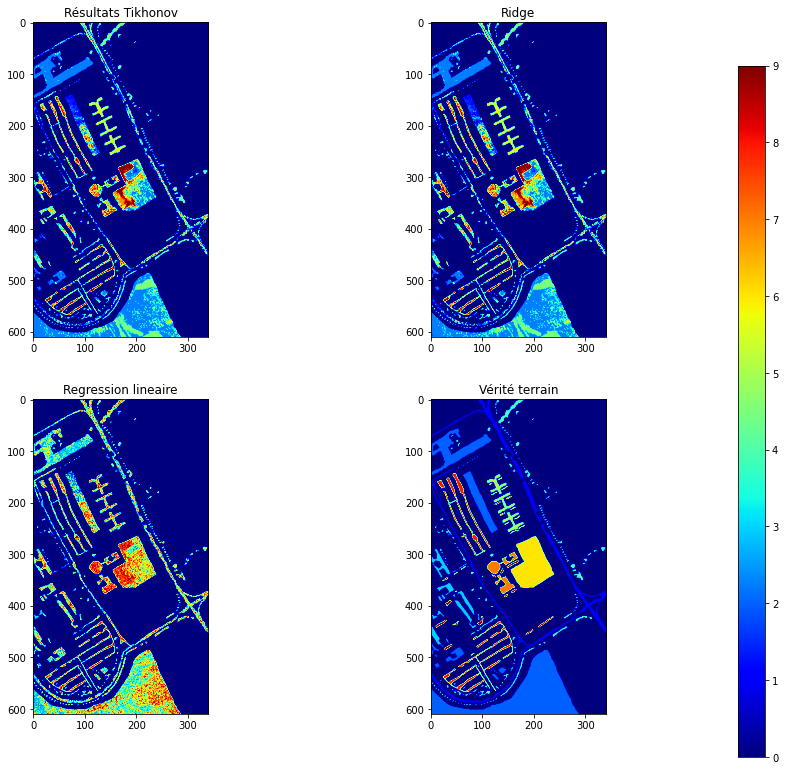

In [48]:
plt.figure(figsize=(15, 12))
plt.subplot(2, 2, 1)
plt.imshow(full_classifier_tik, cmap='jet')
plt.title('Résultats Tikhonov')

plt.subplot(2, 2, 2)
plt.imshow(full_classifier_tik_sk, cmap='jet')
plt.title('Ridge')

plt.subplot(2, 2, 3)
plt.imshow(full_classifier, cmap='jet')
plt.title('Regression lineaire')

plt.subplot(2, 2, 4)
plt.imshow(gt, cmap='jet')
plt.title('Vérité terrain')

plt.subplots_adjust(bottom=0.1, right=0.8, top=0.9)
cax = plt.axes([0.85, 0.05, 0.025, 0.8])
plt.colorbar(imgt, cax=cax)

plt.show()

En comparant seulement Tikhonov et Ridge, nous remarquons une fois de plus que les résultats obtenus sont similaires.

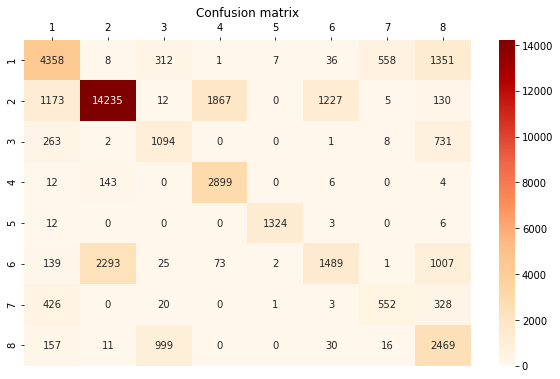

In [49]:
plot_confusion_matrix(gt_usefull, full_classifier_tik[full_classifier_tik != 0], class_names=np.arange(1, 9), log=False)

Sur cette matrice de confusion, la diagonale est un peu plus visible. On remarque notamment qu'il y a moins d'erreurs pour la classe 2.

In [50]:
print('Tikhonov: classification report')
print()
print(classification_report(gt_usefull, full_classifier_tik[full_classifier_tik != 0]))

Tikhonov: classification report

              precision    recall  f1-score   support

           1       0.67      0.66      0.66      6631
           2       0.85      0.76      0.81     18649
           3       0.44      0.52      0.48      2099
           4       0.60      0.95      0.73      3064
           5       0.99      0.98      0.99      1345
           6       0.53      0.30      0.38      5029
           7       0.48      0.42      0.45      1330
           8       0.41      0.67      0.51      3682

    accuracy                           0.68     41829
   macro avg       0.62      0.66      0.63     41829
weighted avg       0.70      0.68      0.68     41829



Nous remarquons sur le rapport de classification que la précision (accuracy) atteint 0.68 ce qui est correcte.\
Nous pouvons également noter que la classification pour la classe 5 est presque parfaite, puisque les trois métriques sont très proches de 1. A l'aide de la matrice de confusion, nous pouvons noter que l'erreur s'effectue sur 10 samples seulement.

### Influence de $\lambda$

In [51]:
classifier_tik2 = np.argmax(phi_tikhonov2.T.reshape(-1, 8), axis=1) + 1
full_classifier_tik2 = np.zeros((Nrow * Ncol))
full_classifier_tik2[usefull_idx] = classifier_tik2
full_classifier_tik2 = full_classifier_tik2.reshape((Nrow, Ncol))

classifier_tik3 = np.argmax(phi_tikhonov3.T.reshape(-1, 8), axis=1) + 1
full_classifier_tik3 = np.zeros((Nrow * Ncol))
full_classifier_tik3[usefull_idx] = classifier_tik3
full_classifier_tik3 = full_classifier_tik3.reshape((Nrow, Ncol))

In [52]:
print(classification_report(gt_usefull, full_classifier_tik2[full_classifier_tik2 != 0]))

              precision    recall  f1-score   support

           1       0.00      0.00      0.00      6631
           2       0.81      0.02      0.03     18649
           3       0.06      0.00      0.01      2099
           4       0.13      1.00      0.23      3064
           5       0.50      1.00      0.67      1345
           6       0.56      0.04      0.08      5029
           7       0.00      0.00      0.00      1330
           8       0.25      1.00      0.41      3682

    accuracy                           0.21     41829
   macro avg       0.29      0.38      0.18     41829
weighted avg       0.48      0.21      0.10     41829



/home/sabine/.local/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/sabine/.local/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/sabine/.local/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [53]:
print(classification_report(gt_usefull, full_classifier_tik3[full_classifier_tik3 != 0]))

              precision    recall  f1-score   support

           1       0.00      0.00      0.00      6631
           2       0.00      0.00      0.00     18649
           3       0.00      0.00      0.00      2099
           4       0.12      1.00      0.22      3064
           5       0.10      1.00      0.18      1345
           6       0.00      0.00      0.00      5029
           7       0.00      0.00      0.00      1330
           8       0.16      0.13      0.14      3682

    accuracy                           0.12     41829
   macro avg       0.05      0.27      0.07     41829
weighted avg       0.03      0.12      0.03     41829



/home/sabine/.local/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/sabine/.local/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/sabine/.local/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Nous pouvons remarquer qu'avec un lambda croissant, la précision (accuracy) diminue. Nous parvenons à la même conclusion lorsqu'il fallait déterminer l'influence de lamda sur les cartes d'erreurs.

## IV. Régularisation LASSO

La régularisation LASSO (pour Least Absolute Shrinkage and Selection Operator), proposée en 1996 par Robert Tibshirani, est très similaire à celle de Tikhonov, sauf que la pénalité prend la forme d'une norme $\mathcal{L}_1$ plutôt qu'une norme $\mathcal{L}_2$. Plus particulièrement, le problème (4) précédent prend la forme de

$$ \arg\min_{\boldsymbol \phi \in \mathbb{R}^m} = \|\mathbf{x} -  \mathbf{E}\boldsymbol \phi \|_2^2 + \lambda \|\boldsymbol \phi \|_1\quad (5)$$

Cette régularisation, que l'on retrouve aussi sous le nom de _basis pursuit_ (une petite recherche bibliographique pourrait vous convaincre que les deux problèmes ne sont pas équivalents. Et pourtant, d'après la dualité Lagrangienne que vous verrez au S9, ils le sont).

Malgré sa forte ressemblance avec la régularisation de Tikhonov, la résolution du problème $(5)$ se passe moins bien puisqu'il n'existe pas de solution analytique dans le cas général (il en existe une dans le cas particulier où $E^T E = Id$, ce qui n'est clairement pas le cas dans notre étude). On doit donc se tourner vers des méthodes itératives, dont le splus utilisées pour la résolution de $(5)$ sont les méthodes LARS (Least Angle Regressions), de gradient proximaux et de descente de gradient par coordonnées.

Dans cette partie, vous allez implémenter la résolution de $(5)$ par descente de gradient par coordonnées. Bien qu'étant la plus abordable sur le plan théorique, cette méthode va vous amenez à toucher du doigt la notion de sous-différentiel, qui est au centre des algos de minimisation de fonctions convexes, mais non nécessairement différentiables.

**Cette partie n'est volontairement pas guidée. La partie II a permis de mettre en place un cadre de résolution et d'analyse du problème des moindres carrés, et la partie III a permis d'ajouter l'aspect régularisation au problème. À vous de jouer :**

**4.1) Cherchez** (vous trouverez une multitude de cours/slides/tutos plus ou moins clairs et didactiques sur le net)**, comprenez, et implémentez l'algorithme du LASSO par descente de gradient par coordonnées**

In [54]:
class Lasso:
    def __init__(self, num_iters=100, lb=0.01):
        self.num_iters = num_iters
        self.lb = lb
    
    def fit(self, E, x, display_mse=False):
        phi = np.ones(shape=(E.shape[1], 1))
        mses = []
        
        # normalization
        E = E / (np.linalg.norm(E, axis=0))
        
        # iterate over number of dimensions
        for i in range(self.num_iters): 
            
            # iterate over dimensions
            for j in range(E.shape[1]):
                e_j = E[:,j]

                # compute rho term
                preds = (E @ phi).flatten()
                rho = e_j.T @ (x - preds  + phi[j] * e_j)

                # update learning params: phi
                if rho < - self.lb:
                    phi[j] = rho + self.lb
                elif rho > self.lb:
                    phi[j] = rho - self.lb
                else:
                    phi[j] = 0.
            
            # compute loss function
            x_hat = (E @ phi).flatten()
            mse = ((x - x_hat)**2).sum(axis=0) / 2.0 + self.lb * np.sum(np.abs(phi), axis=0)
            if display_mse:
                print("{:3}\t{:.5f}".format(i, mse[0]))
            mses.append(mse)
                    
        return phi.flatten(), np.array(mses)
    
    def fit_all(self, E, x, display_mse=False):
        self.phi = np.zeros((E.shape[1], x.shape[1]))
        
        # precompute z: shape=(E.shape[1],)=(n_features,)
        z = (E**2).sum(axis=0)
        
        mses = []

        # iterate over number of dimensions
        for i in range(self.num_iters):
            
            # compute loss function
            x_hat = E @ self.phi
            mse = ((x - x_hat)**2).sum(axis=0)[0] / 2.0 + self.lb * np.sum(np.abs(self.phi), axis=0)[0]
            if display_mse:
                print("{:3}\t{:.5f}".format(i, mse))
            
            mses.append(mse)
            # iterate over dimensions
            for j in range(E.shape[1]):             
                z_j = z[j]
                e_j = E[:, j].reshape((-1, 1))

                # don't want to consider this term in the sum
                theta_x_j = e_j @ self.phi[j].reshape((1, -1))
                
                # compute rho term
                # preds: shape=(E.shape[0], x.shape[1])=(n_samples, nb_dim_pred_var)
                preds = E @ self.phi
                rho = e_j.T @ (x - preds + theta_x_j)
                
                # update learning params: phi
                rho = rho.reshape((rho.shape[1],))
                self.phi[j][rho < -self.lb] = (rho[rho < -self.lb] + self.lb) / z_j
                self.phi[j][(rho >= -self.lb) & (rho =< self.lb)] = 0.
                self.phi[j][rho > self.lb] = (rho[rho > self.lb] - self.lb) / z_j
                
        print(mses[-1])
        return mses

In [55]:
l_model = Lasso(lb=0.15, num_iters=200)

In [56]:
_ = l_model.fit(E, hsi_usefull[0], True)

  0	1.66540
  1	1.51452
  2	1.42927
  3	1.34815
  4	1.26905
  5	1.19098
  6	1.11341
  7	1.02678
  8	0.94393
  9	0.86195
 10	0.77997
 11	0.69730
 12	0.61351
 13	0.52192
 14	0.44417
 15	0.44410
 16	0.44404
 17	0.44397
 18	0.44391
 19	0.44384
 20	0.44378
 21	0.44372
 22	0.44365
 23	0.44359
 24	0.44353
 25	0.44347
 26	0.44341
 27	0.44335
 28	0.44329
 29	0.44323
 30	0.44318
 31	0.44312
 32	0.44306
 33	0.44301
 34	0.44295
 35	0.44289
 36	0.44284
 37	0.44279
 38	0.44273
 39	0.44268
 40	0.44263
 41	0.44258
 42	0.44252
 43	0.44247
 44	0.44242
 45	0.44237
 46	0.44232
 47	0.44227
 48	0.44222
 49	0.44218
 50	0.44213
 51	0.44208
 52	0.44203
 53	0.44199
 54	0.44194
 55	0.44190
 56	0.44185
 57	0.44181
 58	0.44176
 59	0.44172
 60	0.44167
 61	0.44163
 62	0.44159
 63	0.44155
 64	0.44150
 65	0.44146
 66	0.44142
 67	0.44138
 68	0.44134
 69	0.44130
 70	0.44126
 71	0.44122
 72	0.44118
 73	0.44115
 74	0.44111
 75	0.44107
 76	0.44103
 77	0.44100
 78	0.44096
 79	0.44092
 80	0.44089
 81	0.44085
 82	0.44082
 83	

Comme nous pouvons le voir, l'erreur diminue à chaque itération ce qui permet d'affirmer que nous parvenons bien à minimiser. Nous allons donc appliquer le fit pour chaque pixel afin d'obtenir la matrice d'abondance $\phi$ pour l'ensemble de l'image.

In [57]:
list_phi = []
list_mse = []

for pixel in hsi_usefull:
    phi, mse = l_model.fit(E, pixel)

    list_phi.append(phi)
    list_mse.append(mse)
    
phis = np.array(list_phi)
mses = np.array(mse)


**4.2) Menez à bien l'analyse qualitative et quantitative des performances du LASSO sur le problème de démélange spectral (aussi bien sur quelques spectres que sur l'image entière), ainsi que toutes les comparaisons qui vous paraîtront pertinentes avec la résolution par moindres carrés ordinaires et moindres carrés avec régularisation de Tikhonov**

In [58]:
classifier_l = np.argmax(phis, axis=1) + 1

full_classifier_l = np.zeros((Nrow * Ncol))
full_classifier_l[usefull_idx] = classifier_l
full_classifier_l = full_classifier_l.reshape((Nrow, Ncol))

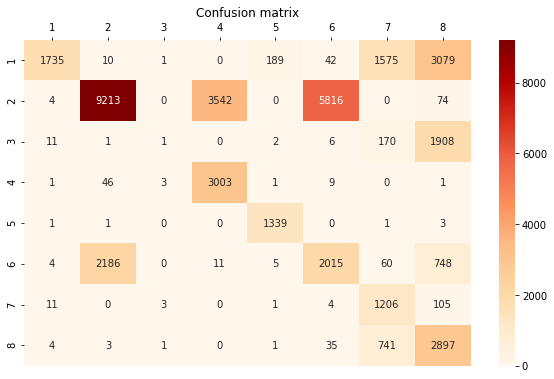

In [59]:
plot_confusion_matrix(gt_usefull, classifier_l, class_names=np.arange(1, 9), log=False)

En analysant la matrice de confusion, il semblerait que la classification semble convenable. En effet, nous parvenons à distringuer la diagonale de la matrice mais il y a tout de meme de nombreuses erreurs sur la partie droite de la matrice. Nous allons donc afficher le rapport de classification.

In [60]:
print(classification_report(gt_usefull, full_classifier_l[full_classifier_l != 0]))

              precision    recall  f1-score   support

           1       0.98      0.26      0.41      6631
           2       0.80      0.49      0.61     18649
           3       0.11      0.00      0.00      2099
           4       0.46      0.98      0.62      3064
           5       0.87      1.00      0.93      1345
           6       0.25      0.40      0.31      5029
           7       0.32      0.91      0.47      1330
           8       0.33      0.79      0.46      3682

    accuracy                           0.51     41829
   macro avg       0.52      0.60      0.48     41829
weighted avg       0.65      0.51      0.51     41829



Comme nous pouvons le voir, nous atteignons une precision (accuracy) de plus de 0.50 ce qui signifie que notre modèle nous parvient à bien classifier plus de 50% des données. 

In [61]:
classifier_l = np.argmax(phis, axis=1) + 1

full_classifier_l = np.zeros((Nrow * Ncol))
full_classifier_l[usefull_idx] = classifier_l
full_classifier_l = full_classifier_l.reshape((Nrow, Ncol))

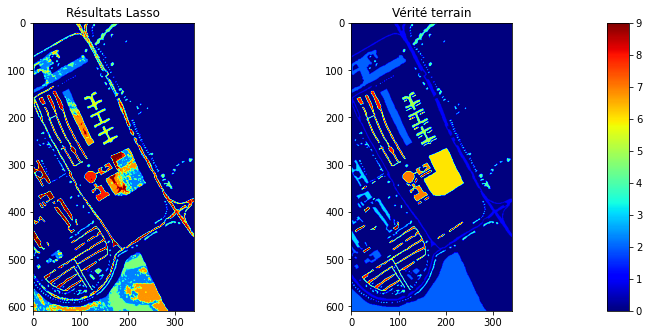

In [62]:
plt.figure(figsize=(12, 8))

plt.subplot(1, 2, 1)
plt.imshow(full_classifier_l, cmap='jet')
plt.title('Résultats Lasso')

plt.subplot(1, 2, 2)
plt.imshow(gt, cmap='jet')
plt.title('Vérité terrain')

plt.subplots_adjust(bottom=0.1, right=0.8, top=0.6)
cax = plt.axes([0.85, 0.1, 0.025, 0.5])
plt.colorbar(imgt, cax=cax)

plt.show()

Nous pouvons également associer chaque pixel selon son abondance fractionnelle majoritaire. Nous pouvons effectivement constater qu'il y a beaucoup d'erreurs notamment sur la classe 8 mais très peu pour la classe 5.

### Carte d'erreurs

In [63]:
l_model = Lasso(lb=0.0005, num_iters=100)
_ = l_model.fit_all(E, hsi_usefull.T)

0.010161910171329207


In [64]:
x_hat = E @ l_model.phi
mses = mean_square_error(hsi_usefull, x_hat.T)

# Build image from errors
full_mses = np.zeros((Nrow * Ncol))
full_mses[usefull_idx] = mses
full_mses = full_mses.reshape((Nrow, Ncol))

In [65]:
print('Min error:\t {}'.format(mses.min()))
print('Max error:\t {}'.format(mses.max()))
print('Mean error:\t {}'.format(mses.mean()))

Min error:	 0.0032638169735766604
Max error:	 0.07026891507321066
Mean error:	 0.011755965702168142


En regardant les valeurs maximale, minimale et moyenne, nous remarquons que ce modèle ne semble pas être adapté pour répondre à nos besoins. Nous allons alors comparer la carte d'erreur avec celles obtenus avec régularisation Tikhonov avec lambda = 1 et 5.

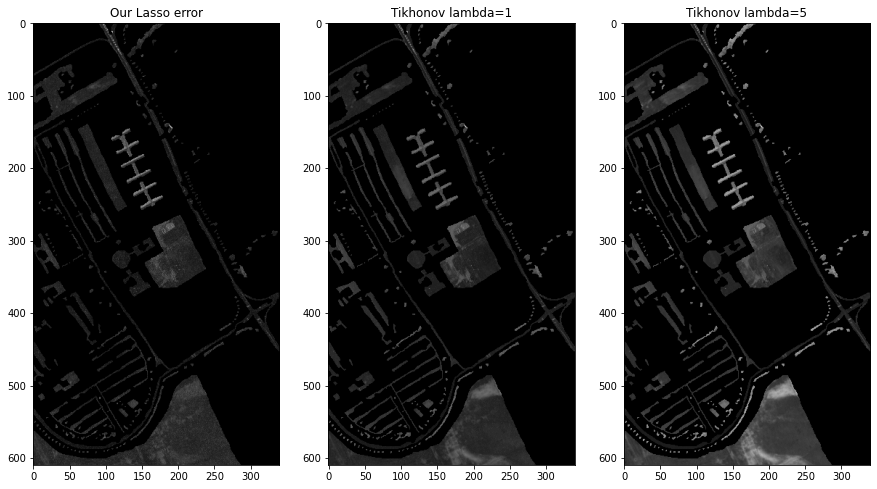

In [66]:
plt.figure(figsize=(15, 12))
plt.subplot(1, 3, 1)
plt.imshow(full_mses, cmap='gray')
plt.title('Our Lasso error')

plt.subplot(1, 3, 2)
plt.imshow(full_mses2, cmap='gray')
plt.title('Tikhonov lambda=1')

plt.subplot(1, 3, 3)
plt.imshow(full_mses3, cmap='gray')
plt.title('Tikhonov lambda=5')

plt.show()

Notons que les pixels de couleur proche du blanc sont ceux ayant une erreur plus importante.


Nous pouvons remarquer que l'erreur obtenue avec Lasso est plus petite que celle obtenue avec Tikhonov lambda=5. En effet, sur la carte de Lasso, les couleurs sont toutes dans un ton bleu alors qu'il y a du jaune pour Tikhonov lambda=5.

Nous pouvons également noter que les erreurs obtenues avec Lasso et avec Tikhonov lambda=1 sont très proches. Nous pouvons remarquer une légère différence sur la partie basse de l'image. Il semblerait que Lasso nous donne des résultats similaires à ceux de Tikhonov lambda=1.

### Comparaison: Lasso Sklearn - notre Lasso

Pour effectuer la comparaison, nous utilisons la même valeur de lambda/alpha.

In [67]:
lasso_sk = Lasso_sk(alpha=0.0004, max_iter=2000, fit_intercept=False, tol=0.001)
lasso_sk.fit(E, hsi_usefull.T)

Lasso(alpha=0.0004, fit_intercept=False, max_iter=2000, tol=0.001)

In [68]:
# Sklearn lasso - build image
reconstruction_l = np.argmax(lasso_sk.coef_.T, axis=0) + 1

reconstruction_img_l_sk = np.zeros((Nrow * Ncol))
reconstruction_img_l_sk[usefull_idx] = reconstruction_l
reconstruction_img_l_sk = reconstruction_img_l_sk.reshape((Nrow, Ncol))

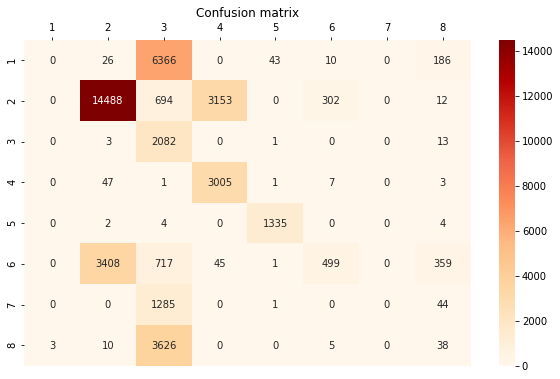

In [69]:
plot_confusion_matrix(gt_usefull, reconstruction_img_l_sk[reconstruction_img_l_sk != 0], class_names=np.arange(1, 9), log=False)

Nous pouvons constater que la diagonale de la matrice est facilement visible ce qui laisse penser que la classificatio est correcte. Cependant, il y a tout de même des erreurs au niveau de la classe 3.

In [70]:
print(classification_report(gt_usefull, reconstruction_img_l_sk[reconstruction_img_l_sk != 0]))

              precision    recall  f1-score   support

           1       0.00      0.00      0.00      6631
           2       0.81      0.78      0.79     18649
           3       0.14      0.99      0.25      2099
           4       0.48      0.98      0.65      3064
           5       0.97      0.99      0.98      1345
           6       0.61      0.10      0.17      5029
           7       0.00      0.00      0.00      1330
           8       0.06      0.01      0.02      3682

    accuracy                           0.51     41829
   macro avg       0.38      0.48      0.36     41829
weighted avg       0.51      0.51      0.47     41829



/home/sabine/.local/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/sabine/.local/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/sabine/.local/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Comme nous pouvons le voir sur le rapport ci-dessus, nous atteignons une précision (accuracy) d'au moins 0.50 ce qui nous permet d'affirmer que ce modèle peut être utilisé pour effectuer un démélange spectral.

In [71]:
# Sklearn lasso - build image
reconstruction_l = E @ lasso_sk.coef_.T

reconstruction_img_l_sk = np.zeros((Nrow * Ncol))
reconstruction_img_l_sk[usefull_idx] = reconstruction_l[12]
reconstruction_img_l_sk = reconstruction_img_l_sk.reshape((Nrow, Ncol))

In [72]:
# Lasso - build image
reconstruction_l = E @ l_model.phi

reconstruction_img_l = np.zeros((Nrow * Ncol))
reconstruction_img_l[usefull_idx] = reconstruction_l[12]
reconstruction_img_l = reconstruction_img_l.reshape((Nrow, Ncol))

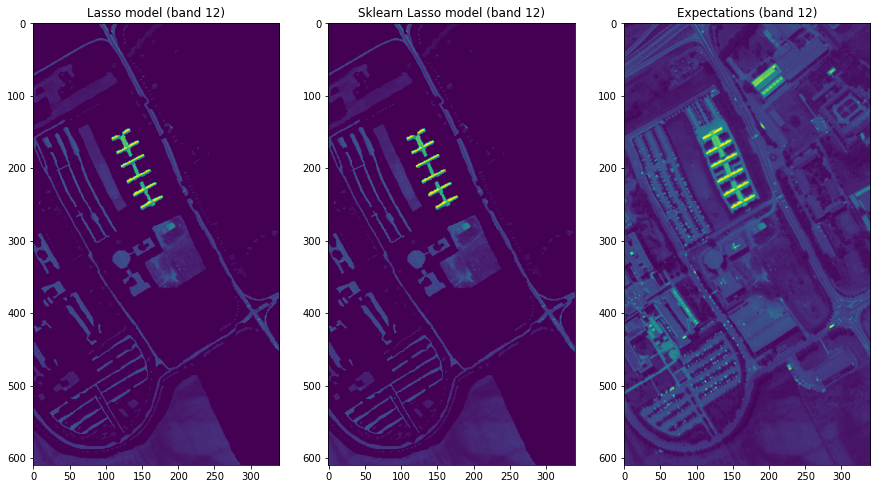

In [73]:
plt.figure(figsize=(15,10))

plt.subplot(1, 3, 1)
plt.title("Lasso model (band 12)")
plt.imshow(reconstruction_img_l)

plt.subplot(1, 3, 2)
plt.title("Sklearn Lasso model (band 12)")
plt.imshow(reconstruction_img_l_sk)

plt.subplot(1, 3, 3)
plt.title("Expectations (band 12)")
plt.imshow(hsi[:, :, 12])

plt.show()

En observant les deux images obtenus avec chacun des modèles de Lasso, on peut remarquer que les résultats sont très proches mais il serait plus judicieux de déterminer l'erreur moyenne entre ces résultats.

In [74]:
err = np.abs(reconstruction_img_l - reconstruction_img_l_sk)
print('Erreur moyenne: {}'.format(err.mean()))
print('Erreur maximale: {}'.format(err.max()))

Erreur moyenne: 0.0006429260852336303
Erreur maximale: 0.016714836428418978


Il semblerait que notre implémentation nous permet d'avoir des résultats similaires à ceux obtenus à partir du modèle de Sklearn. En effet, l'erreur moyenne est de 0.0006 (ordre de grandeur au millième) et l'erreur maximale est de 0.02.

In [75]:
coefs = np.zeros((Nrow * Ncol, 8))
coefs[usefull_idx] = lasso_sk.coef_
coefs = coefs.reshape((Nrow, Ncol, 8))

In [76]:
full_phi = np.zeros((Nrow * Ncol, 8))
full_phi[usefull_idx] = l_model.phi.T
full_phi = full_phi.reshape((Nrow, Ncol, 8))

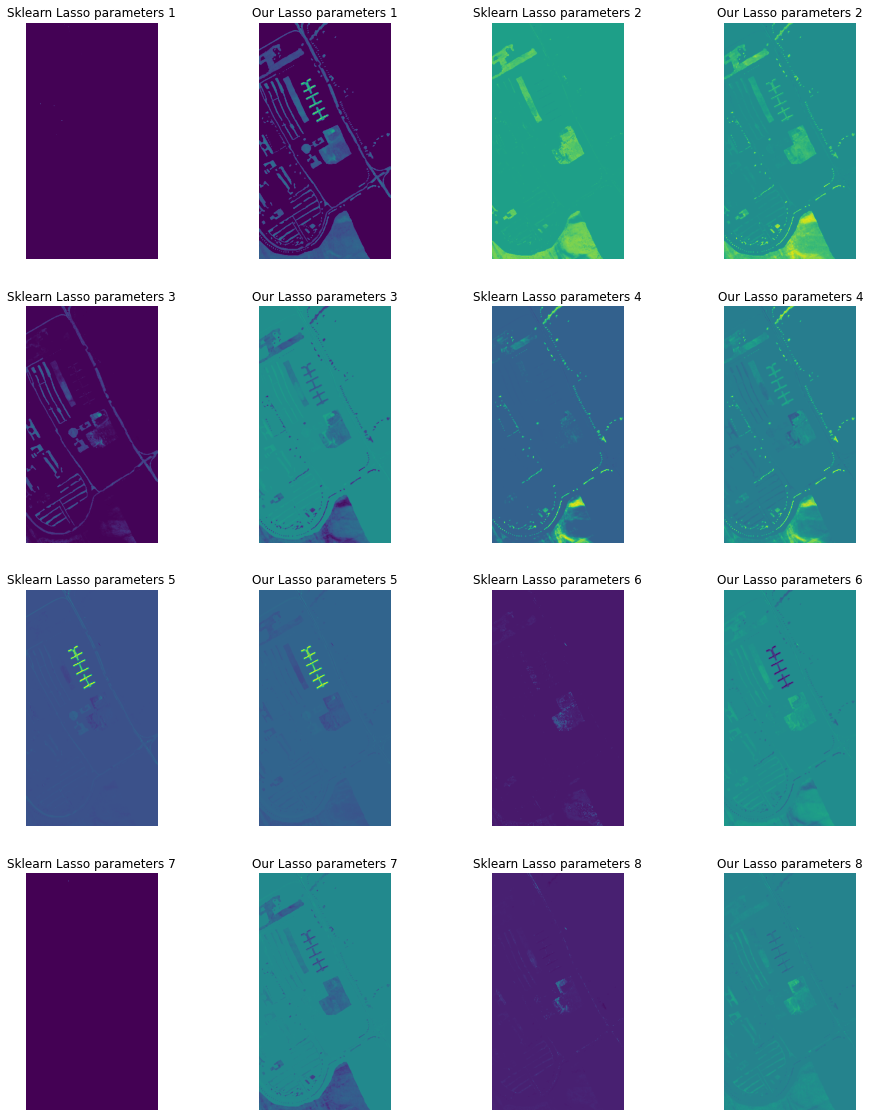

In [77]:
plt.figure(figsize=(16,20))

for i in range(8):
    plt.subplot(4, 4, 2 * i + 1)
    plt.title('Sklearn Lasso parameters {}'.format(i + 1))
    plt.imshow(coefs[:, :, i])
    plt.axis('off')
    
    plt.subplot(4, 4, 2 * i + 2)
    plt.title('Our Lasso parameters {}'.format(i + 1))
    plt.imshow(full_phi[:, :, i])
    plt.axis('off')
    
plt.show()

Nous pouvons remarquer que sur certaines cartes de l'implémentation Lasso de Sklearn, nous ne distinguons aucun motif (1, 3 et 7). Cependant, nous obtenons des resultats similaires pour les cartes 2, 4 et 5.

### Influence de $\lambda$

Pour déterminer l'influence de lambda, nous pouvons comparer la MSE de chaque modèle pour un même nombre d'itérations (ici 20). Notons que fixer un nombre d'itérations pour chaque modèle n'est pas optimale car il est possible que la MSE décroit très lentement.

In [78]:
l_model_lambda_0 = Lasso(lb=0.0005, num_iters=20)
mse_lambda_0 = l_model_lambda_0.fit_all(E, hsi_usefull.T, False)

0.012437313431017134


In [79]:
l_model_lambda_0_5 = Lasso(lb=0.5, num_iters=20)
mse_lambda_0_5 = l_model_lambda_0_5.fit_all(E, hsi_usefull.T, False)

0.5722237899111499


In [80]:
l_model_lambda_1 = Lasso(lb=1, num_iters=20)
mse_lambda_1 = l_model_lambda_1.fit_all(E, hsi_usefull.T, False)

0.9108393163397696


In [81]:
l_model_lambda_5 = Lasso(lb=5, num_iters=20)
mse_lambda_5 = l_model_lambda_5.fit_all(E, hsi_usefull.T, False)

2.738075796195357


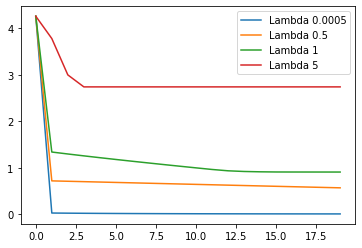

In [82]:
plt.plot(mse_lambda_0, label='Lambda 0.0005')
plt.plot(mse_lambda_0_5, label='Lambda 0.5')
plt.plot(mse_lambda_1, label='Lambda 1')
plt.plot(mse_lambda_5, label='Lambda 5')
plt.legend()
plt.show()

Nous pouvons constater que lorsque lambda augmente, la MSE décroit moins rapidement. Nous pouvons également noter que celui-ci semble converger vers une valeur non nulle lorsque lambda est trop grand. C'est notamment le cas lorsque lambda est à 5, la MSE est constante à partir de 3 itérations (nous affichons les valeurs qu'à 1e-5).

Il est préférable d'avoir un lambda petit.

### Comparaison entre les modèles

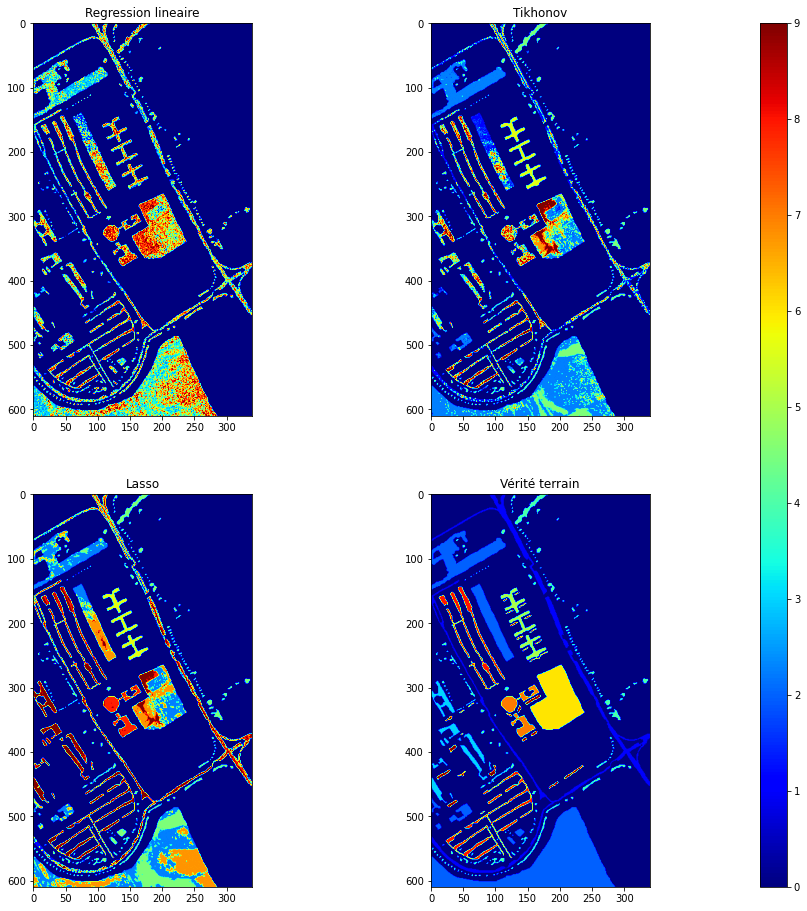

In [83]:
plt.figure(figsize=(15, 15))

plt.subplot(2, 2, 1)
plt.imshow(full_classifier, cmap='jet')
plt.title('Regression lineaire')

plt.subplot(2, 2, 2)
plt.imshow(full_classifier_tik, cmap='jet')
plt.title('Tikhonov')

plt.subplot(2, 2, 3)
plt.imshow(full_classifier_l, cmap='jet')
plt.title('Lasso')

plt.subplot(2, 2, 4)
plt.imshow(gt, cmap='jet')
plt.title('Vérité terrain')

plt.subplots_adjust(bottom=0.1, right=0.8, top=0.9)
cax = plt.axes([0.85, 0.1, 0.025, 0.8])
plt.colorbar(imgt, cax=cax)

plt.show()

Nous aurions pu afficher les cartes d'abondances de chaque endmembers pour chaque modele mais cela ne nous permet pas d'avoir une idée globale de l'efficacité de chacun des modèle.\
Nous avons alors décidé de reconstruire les images pour chaque modèle et de les comparer avec la vérité terrain.

Comparaison Régression linéaire/moindres carrées et vérité terrain:\
Nous pouvons noter que pour chaque motif présent, il n'y a aucune couleur dominante dû au fait que la classification n'est pas efficace. Par exemple, pour la partie basse de l'image, les classes/couleurs présentes sont 4, 6, 7 et 8 alors que celle qui est attendue est 2. 

Comparaison Tikhonov et vérité terrain:\
La classification semble meilleure que celle de regression linéaire. En effet, certains motifs (x=50, y=100 et x=160, y=50) sont correctement classifiés malgré un peu de bruit. Nous pouvons également noter que sur la partie basse de l'image, la classification semble meilleure que la précédente (moins de bruits notamment).

Comparaison Lasso et vérité terrain:\
Comme nous pouvons le voir, la classification est convenable mais il y a beaucoup d'erreurs sur certaines classes. On peut noter que la classe 8 est très présente alors qu'elle n'apparait pas beaucoup sur la vérité terrain.



**4.3) Explicitez les conclusions que vous pouvez en tirer, et quelle méthode de résolution vous paraît la plus favorable étant données notamment les contraintes physiques de positivité et de somme à un sur les abondances (qui ne sont pas prises en compte ici).**

Nous avons pu remarquer que la classification semble difficile sur nos données. Nous avons essayé plusieurs méthodes (moindres carrées, régularisation tikhonov, régularisation lasso) avec de légères modifications pour chacune et les résultats obtenus étaient très variables.

Les résultats obtenus avec Lasso étaient dans l'ensemble convenables (precision de 0.50). En reconstruisant notre image, nous remarquons que certaines classes sont très présentes et d'autres quasi absentes. Nous avons pu noter que la carte d'erreur de Lasso était très proche de celle de Tikhonov lambda=1.

Pour déterminer l'efficacité de la régularisation de Tikhonov, nous avons testé ce modèle avec des paramètres lambda différents. Nous avons pu noter que l'erreur quadratique moyenne était minimale lorsque lambda était proche de 0. La régularisation lasso nous donnait donc des résultats moins bon que ceux de Tikhonov avec un lambda inférieur à 1. (Nous avons également pu remarquer que la MSE est constante à partir d'un certain nombre d'itérations quand lambda est grand).

La méthode des moindres carrées nous permettait d'obtenir des valeurs de MSE très faible (ordre de grandeur au centième) mais lorsque nous reconstruisions l'image, nous avons pu observer des zones assez bruitées. En comparant cette méthode avec la régularisation de Tikhonov, nous remarquons qu'il s'agit de la seconde qui nous donne de meilleurs résultats. En effet, nous obtenons une précision de 0.28 avec la méthode des moindres carrées et une précision de plus de 0.60 avec la régularisation de Tikhonov.

En conclusion, les méthodes utilisées ne prennent pas en compte le fait que nous avons aucune contrainte. En effet, nous avons des valeurs d'abondance fractionnelle négatives alors qu'elles correspondent à des probabilités. De même, nous n'avons pas pris en compte le fait que la somme doit être égale à 1. Cependant, la meilleure méthode utilisée pour classifier est celle avec régularisation de Tikhonov (précision de +0.60).